In [63]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Acquiring the dataset
num_of_frames=52
root_dir_path = os.path.dirname(os.path.abspath("__file__"))
image_dir = os.path.join(root_dir_path, 'data/rgb')
depth_dir = os.path.join(root_dir_path, 'data/depth')

images_rgb=[]
images=[]
depth_maps=[]
for i in range(1,num_of_frames+1):
    zeroes = "0" * (5 - len(str(i)))
    im_name = "{0}/frame_{1}{2}.png".format(image_dir,zeroes,str(i))
    images.append(cv2.imread(im_name, flags=0))
    images_rgb.append(cv2.imread(im_name)[:, :, ::-1])
    depth_name = '{0}/utf-8frame_{1}{2}.dat'.format(depth_dir,zeroes, str(i))
    depth = np.loadtxt(depth_name,delimiter=',',dtype=np.float64) * 1000.0
    depth_maps.append(depth)

#Calibration Matrix
k = np.array([[640, 0, 640],
                   [0, 480, 480],
                   [0,   0,   1]], dtype=np.float32)

In [3]:
def extract_features(image,method):
    if method=='surf':
        surf = cv2.xfeatures2d.SURF_create(500)
        kp, des = surf.detectAndCompute(image,None)
        return kp, des
    elif method=='sift':
        sift = cv2.xfeatures2d.SIFT_create()
        kp, des = sift.detectAndCompute(image, None)
        return kp, des
    elif method=='FAST':
        featuredetect = cv2.FastFeatureDetector_create(threshold = 25, nonmaxSuppression = True)
        kp = featuredetect.detect(image)
        return kp

In [30]:
def extract_features_dataset(images,extract_features_function):
    kp_list = []
    des_list = []
    for img in images:
        kp, des = extract_features(img,'surf')
        kp_list.append(kp)
        des_list.append(des)
    return kp_list, des_list
def match_features(des1, des2):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50) 
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    match = flann.knnMatch(des1,des2,k=2)
    return match
def filter_matches_distance(match, dist_threshold=0.6):
    filtered_match = []
    for i,(m,n) in enumerate(match):
        if m.distance < dist_threshold*n.distance:
            filtered_match.append(m)
    return filtered_match
def visualize_matches(image1, kp1, image2, kp2, match):
    image_matches = cv2.drawMatches(image1,kp1,image2,kp2,match,None,flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)
def match_features_dataset(des_list, match_features):
    matches = []
    for i in range(len(des_list)-1):
        des1= des_list[i]
        des2= des_list[i+1]
        match = match_features(des1, des2)
        matches.append(match)
    return matches
def filter_matches_dataset(filter_matches_distance, matches, dist_threshold):
    filtered_matches = []
    for m in matches:
        new_match = filter_matches_distance(m, dist_threshold)
        filtered_matches.append(new_match)
    return filtered_matches

Features matched in frames 0 and 1 = 1372
Filtered matches in frames 0 and 1 = 492


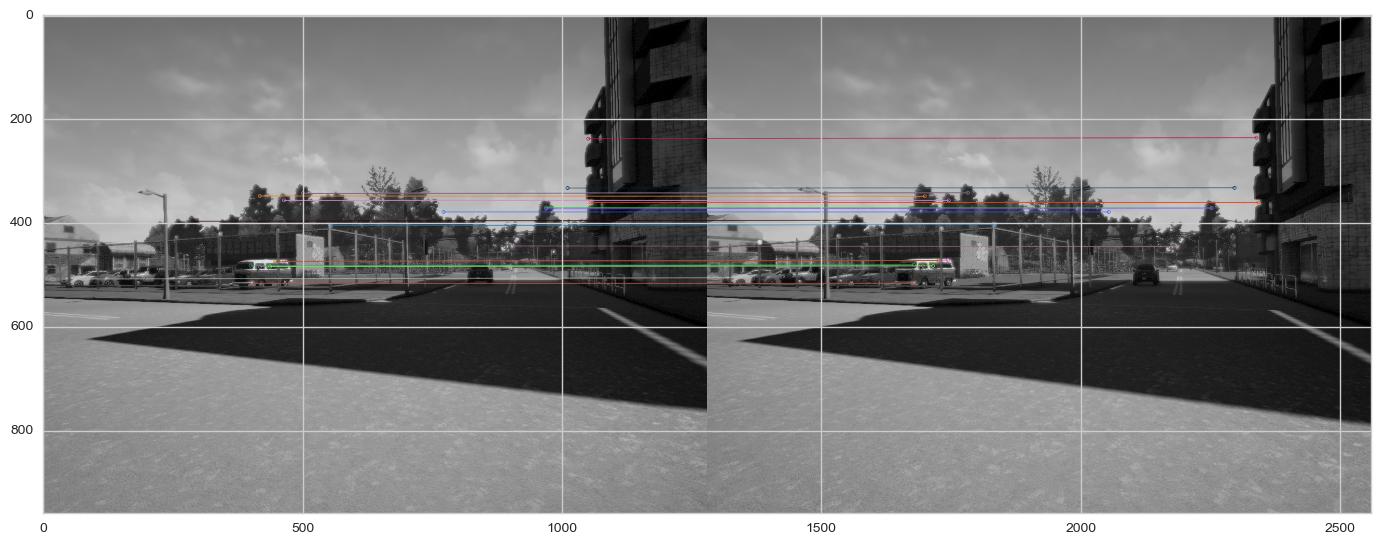

In [116]:
image1 = images[0]
image2 = images[1]

kp1 = kp_list[0]
kp2 = kp_list[1]

des1 = des_list[0]
des2 = des_list[1]

match = match_features(des1, des2)
match = filter_matches_distance(match, 0.5)
image_matches = visualize_matches(image1, kp1, image2, kp2, match[:20]) 

matches = match_features_dataset(des_list, match_features)
print("Features matched in frames {0} and {1} = {2}".format(0, 1, len(matches[0])))

filtered_matches = filter_matches_dataset(filter_matches_distance, matches, 0.6)
matches=filtered_matches
print("Filtered matches in frames {0} and {1} = {2}".format(0, 1, len(filtered_matches[0])))

In [40]:
def estimate_motion(match, kp1, kp2, k, depth1=None):
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []
    for m in match:
        train_idx = m.trainIdx
        query_idx = m.queryIdx
        
        p1x, p1y = kp1[query_idx].pt
        image1_points.append([p1x, p1y])

        p2x, p2y = kp2[train_idx].pt
        image2_points.append([p2x, p2y])

    E, mask = cv2.findEssentialMat(np.array(image1_points), np.array(image2_points), k)
    retval, rmat, tvec, mask = cv2.recoverPose(E, np.array(image1_points), np.array(image2_points), k)
    
    return rmat, tvec, image1_points, image2_points
def estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=[]):
    trajectory = [np.array([0, 0, 0])]
    R = np.diag([1,1,1])
    T = np.zeros([3, 1])
    RT = np.hstack([R, T])
    RT = np.vstack([RT, np.zeros([1, 4])])
    RT[-1, -1] = 1
    
    for i in range(len(matches)):     
        match = matches[i]
        kp1 = kp_list[i]
        kp2 = kp_list[i+1]
        rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k)
        rt_mtx = np.hstack([rmat, tvec])
        rt_mtx = np.vstack([rt_mtx, np.zeros([1, 4])])
        rt_mtx[-1, -1] = 1
        rt_mtx_inv = np.linalg.inv(rt_mtx)
        
        RT = np.dot(RT, rt_mtx_inv)
        new_trajectory = RT[:3, 3]
        trajectory.append(new_trajectory)
    
    trajectory = np.array(trajectory).T
    return trajectory

In [47]:
#Features Extraction
images_ = images
kp_list, des_list = extract_features_dataset(images_, extract_features)

#Feature Matching
matches = match_features_dataset(des_list, match_features)

#Filtering matches
dist_threshold = 0.75
filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)
matches = filtered_matches

#Trajectory Estimation
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k)


In [51]:
print("Trajectory X:\n {0}".format(trajectory[0,:].reshape((1,-1))))
print("Trajectory Y:\n {0}".format(trajectory[1,:].reshape((1,-1))))
print("Trajectory Z:\n {0}".format(trajectory[2,:].reshape((1,-1))))

Trajectory X:
 [[  0.          -0.03243405  -0.18660344  -0.3236289   -0.47184704
   -0.6627087   -0.55243673  -0.68939528  -0.61638018  -0.78292132
   -0.80423579  -1.01009588  -1.07509622  -1.20600489  -1.61833631
   -1.98676969  -2.55250111  -2.95375154  -3.27233417  -3.60236583
   -3.91743619  -4.36127577  -4.93158464  -5.40025878  -6.06884067
   -6.69985491  -7.18925072  -7.64300163  -7.96652448  -8.48393302
   -9.11253606  -9.75815069 -10.53207089 -11.36403317 -12.2072179
  -13.07997578 -14.00987223 -14.97087768 -15.9567783  -16.9505353
  -17.94514427 -18.94104959 -19.94001335 -20.93912201 -21.93813024
  -22.92899476 -23.90865748 -24.86647927 -25.66078308 -26.52800532
  -27.34952843 -28.16952306]]
Trajectory Y:
 [[ 0.          0.01007064  0.057471    0.00392456 -0.12208172 -0.02410338
  -0.0106529   0.0085644   0.07291477  0.04181622  0.11688002  0.17935612
   0.28046167  0.28901781  0.29595214  0.2644444   0.3228807   0.28729377
   0.2570991   0.2315583   0.26233788  0.27112926 

In [139]:
#Visualizing Trajectory
def visualize_trajectory(trajectory):

    locX = trajectory[0,:]
    locY = trajectory[1,:]
    locZ = trajectory[2,:]

    maxX = np.max(locX) +40
    minX = np.min(locX) -40
    maxY = np.max(locY)+30
    minY = np.min(locY) -30
    maxZ = np.max(locZ)+40
    minZ = np.min(locZ)-40
    
    locX=locX.tolist()
    locY=locY.tolist()
    locZ=locZ.tolist()

    auxY_line = locY[0] + locY[-1]
    if maxY > 0 and minY > 0:
        minY = auxY_line - (maxY - minY) / 2
        maxY = auxY_line + (maxY - minY) / 2
    elif maxY < 0 and minY < 0:
        minY = auxY_line + (minY - maxY) / 2
        maxY = auxY_line - (minY - maxY) / 2
    else:
        minY = auxY_line - (maxY - minY) / 2
        maxY = auxY_line + (maxY - minY) / 2

    # Set styles
    mpl.rc("figure", facecolor="white")
    plt.style.use('seaborn-whitegrid')

    # Plot the figure
    fig = plt.figure(figsize=(8, 6), dpi=100)
    gspec = gridspec.GridSpec(3, 3)
    ZY_plt = plt.subplot(gspec[0, 1:])
    YX_plt = plt.subplot(gspec[1:, 0])
    traj_main_plt = plt.subplot(gspec[1:, 1:])
    D3_plt = plt.subplot(gspec[0, 0], projection='3d')

    # Actual trajectory plotting ZX
    toffset = 1.06
    traj_main_plt.set_title("Autonomous vehicle trajectory (Z, X)", y=toffset)
    traj_main_plt.set_title("Trajectory (Z, X)", y=1)
    traj_main_plt.plot(locZ, locX, ".-", label="Trajectory", linewidth=1, markersize=4)
    traj_main_plt.set_xlabel("Z")

    # Plot reference lines
    traj_main_plt.plot([locZ[0], locZ[-1]], [locX[0], locX[-1]], "--", label="Auxiliary line", linewidth=1)
    # Plot camera initial location
    traj_main_plt.scatter([0], [0], s=8, c="red", label="Start location", zorder=2)
    traj_main_plt.set_xlim([minX, maxX])
    traj_main_plt.set_ylim([minY, maxY])
    traj_main_plt.legend(loc=1, title="Legend", borderaxespad=0., fontsize="medium", frameon=True)

    # Plot ZY

    ZY_plt.set_ylabel("Y", labelpad=-4)
    ZY_plt.axes.xaxis.set_ticklabels([])
    ZY_plt.plot(locZ, locY, ".-", linewidth=1, markersize=4, zorder=0)
    ZY_plt.plot([locZ[0], locZ[-1]], [(locY[0] + locY[-1]) / 2, (locY[0] + locY[-1]) / 2], "--", linewidth=1)
    ZY_plt.scatter([0], [0], s=8, c="red", label="Start location")
    ZY_plt.set_xlim([minZ, maxZ])
    ZY_plt.set_ylim([minY, maxY])

    # Plot YX

    YX_plt.set_ylabel("X")
    YX_plt.set_xlabel("Y")
    YX_plt.plot(locY, locX, ".-", linewidth=1, markersize=4)
    YX_plt.plot([(locY[0] + locY[-1]) / 2, (locY[0] + locY[-1]) / 2], [locX[0], locX[-1]], "--", linewidth=1)
    YX_plt.scatter([0], [0], s=8, c="red", label="Start location")
    YX_plt.set_xlim([minY, maxY])
    YX_plt.set_ylim([minX, maxX])

    # Plot 3D
    D3_plt.set_title("3D trajectory", y=toffset)
    D3_plt.plot3D(locX, locZ, locY)
    D3_plt.scatter(0, 0, 0, s=8, c="red")
    D3_plt.set_xlim3d(minX, maxX)
    D3_plt.set_ylim3d(minY, maxY)
    D3_plt.set_zlim3d(minZ, maxZ)
    D3_plt.tick_params(direction='out', pad=-2)
    D3_plt.set_xlabel("X", labelpad=0)
    D3_plt.set_ylabel("Z", labelpad=0)
    D3_plt.set_zlabel("Y", labelpad=-2)
    
    # plt.axis('equal')
    D3_plt.view_init(45, azim=30)
    plt.tight_layout()
    plt.show()

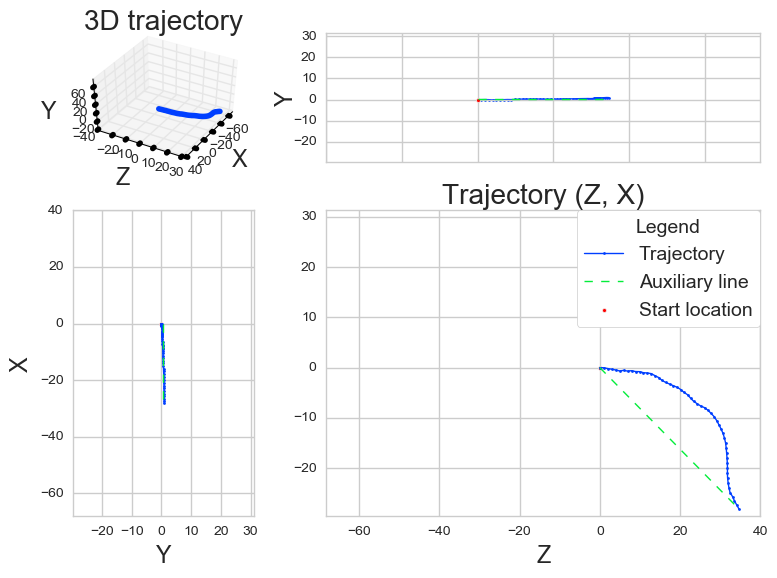

In [140]:
visualize_trajectory(trajectory)